# VAE on HSC images

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import torch
from datasets import load_from_disk

from galgenai import VAE, get_device, get_device_name


device = get_device()
print(f"Using device: {get_device_name()}")

Using device: cuda


## Load and inspect data

In [2]:
# dataset_raw = load_from_disk("../data/hsc_mmu_mini/")
dataset_raw = load_from_disk("/data/a/cpac/fkeruzore/hsc_mmu/")
dataset_raw = dataset_raw.select_columns(["image"]).with_format("torch")

n_gals = len(dataset_raw)
bands = dataset_raw[0]["image"]["band"]

# dataset.set_transform(lambda data: {"flux": data["image"]["flux"]})
# dataset = dataset.map(lambda x: {"flux": x["image"]["flux"]}, remove_columns=["image"])

# min/max
mins = torch.Tensor(-2 * np.ones(len(bands)))
maxs = torch.Tensor(99 * np.ones(len(bands)))


class FluxDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        hf_dataset,
        nx: int,
        mins: torch.TensorType,
        maxs: torch.TensorType,
    ):
        self.dataset = hf_dataset

        # crop to 128
        self.og_nx2 = self.dataset[0]["image"]["flux"].shape[1] // 2
        self.og_ny2 = self.dataset[0]["image"]["flux"].shape[2] // 2
        self.nx2 = nx // 2

        # norms
        self.mins = mins[:, None, None]
        self.maxs = maxs[:, None, None]

    def __len__(self):
        return len(self.dataset)

    def normalize(self, img):
        return (img - self.mins) / (self.maxs - self.mins)

    def crop(self, img):
        return img[
            :,
            self.og_nx2 - self.nx2 : self.og_nx2 + self.nx2,
            self.og_ny2 - self.nx2 : self.og_ny2 + self.nx2,
        ]

    def __getitem__(self, idx):
        image_data = self.dataset[idx]["image"]

        # Extract and crop flux
        flux = self.crop(image_data["flux"])
        # flux_normalized = self.normalize(flux)
        flux_normalized = flux

        # Extract and crop inverse variance
        ivar = self.crop(image_data["ivar"])
        # ivar_normalized = self.normalize(ivar**(-0.5)) ** (-2)
        ivar_normalized = ivar

        # Extract and crop mask
        mask = self.crop(image_data["mask"])

        return flux_normalized, ivar_normalized, mask


dataset = FluxDataset(dataset_raw, nx=64, mins=mins, maxs=maxs)
n_bands, n_x, n_y = dataset[0][0].shape  # First element of tuple is flux
assert n_x == n_y
assert len(bands) == n_bands
print(f"Images dimension: {n_bands}*{n_x}*{n_y} ({n_gals} galaxies)")

Images dimension: 5*64*64 (86614 galaxies)


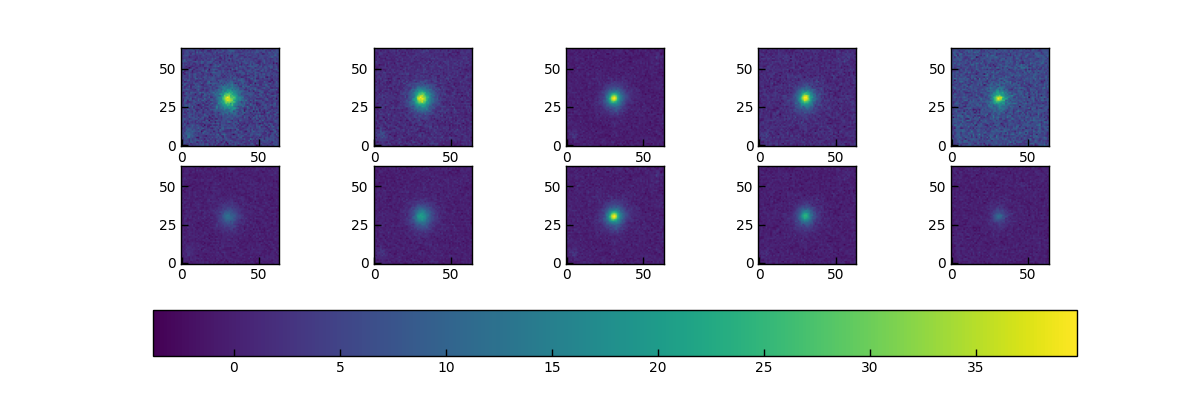

In [3]:
i = 64

img = dataset[i][0]
ivar = dataset[i][1]
msk = dataset[i][2]
snr = img * ivar**0.5 * msk

fig, axs = plt.subplots(2, 5, figsize=(12, 4))
for j in range(5):
    axs[0, j].imshow(img[j], origin="lower")
    im = axs[1, j].imshow(snr[j], origin="lower", vmin=snr.min(), vmax=snr.max())
fig.colorbar(im, ax=axs, orientation="horizontal")

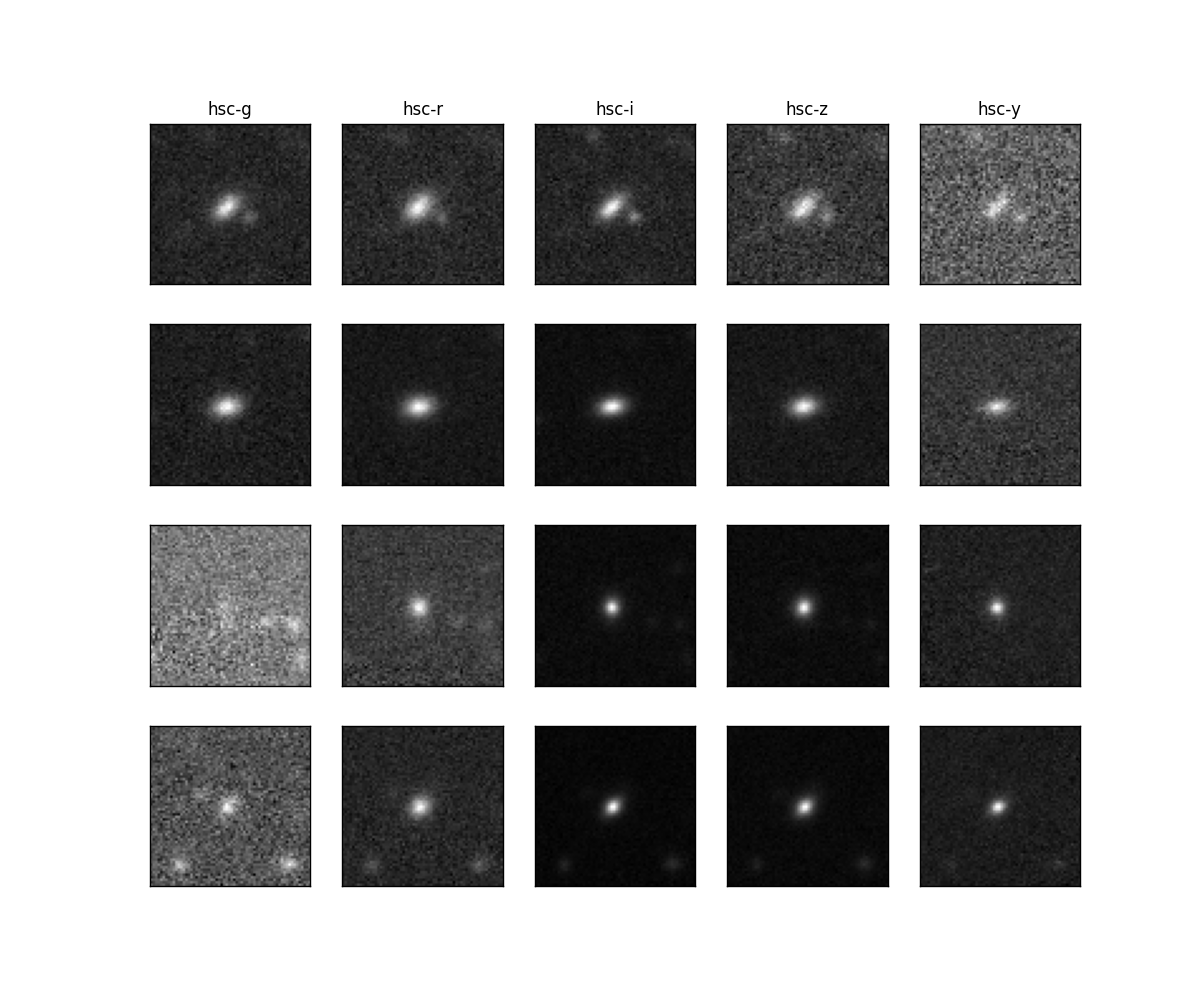

In [4]:
_n_plot = 4
fig, axs = plt.subplots(_n_plot, n_bands, figsize=(12, 10))

for i in range(_n_plot):
    axs_row = axs[i]
    flux, ivar, mask = dataset[i]
    for im, band, ax in zip(flux, bands, axs_row, strict=True):
        ax.imshow(im, origin="lower", cmap="gray")
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        if i == 0:
            ax.set_title(band)

## Define model

In [5]:
model = VAE(in_channels=n_bands, latent_dim=32, input_size=n_x).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

Model parameters: 53,202,325


In [6]:
x = torch.randn(4, n_bands, n_x, n_y).to(device)  # batch
print(f"Input shape: {x.shape}")

reconstruction, mu, logvar = model(x)
print(f"Reconstruction shape: {reconstruction.shape}")
print(f"Latent mean shape: {mu.shape}")
print(f"Latent log variance shape: {logvar.shape}")

Input shape: torch.Size([4, 5, 64, 64])
Reconstruction shape: torch.Size([4, 5, 64, 64])
Latent mean shape: torch.Size([4, 32])
Latent log variance shape: torch.Size([4, 32])


## Check pre-training outputs

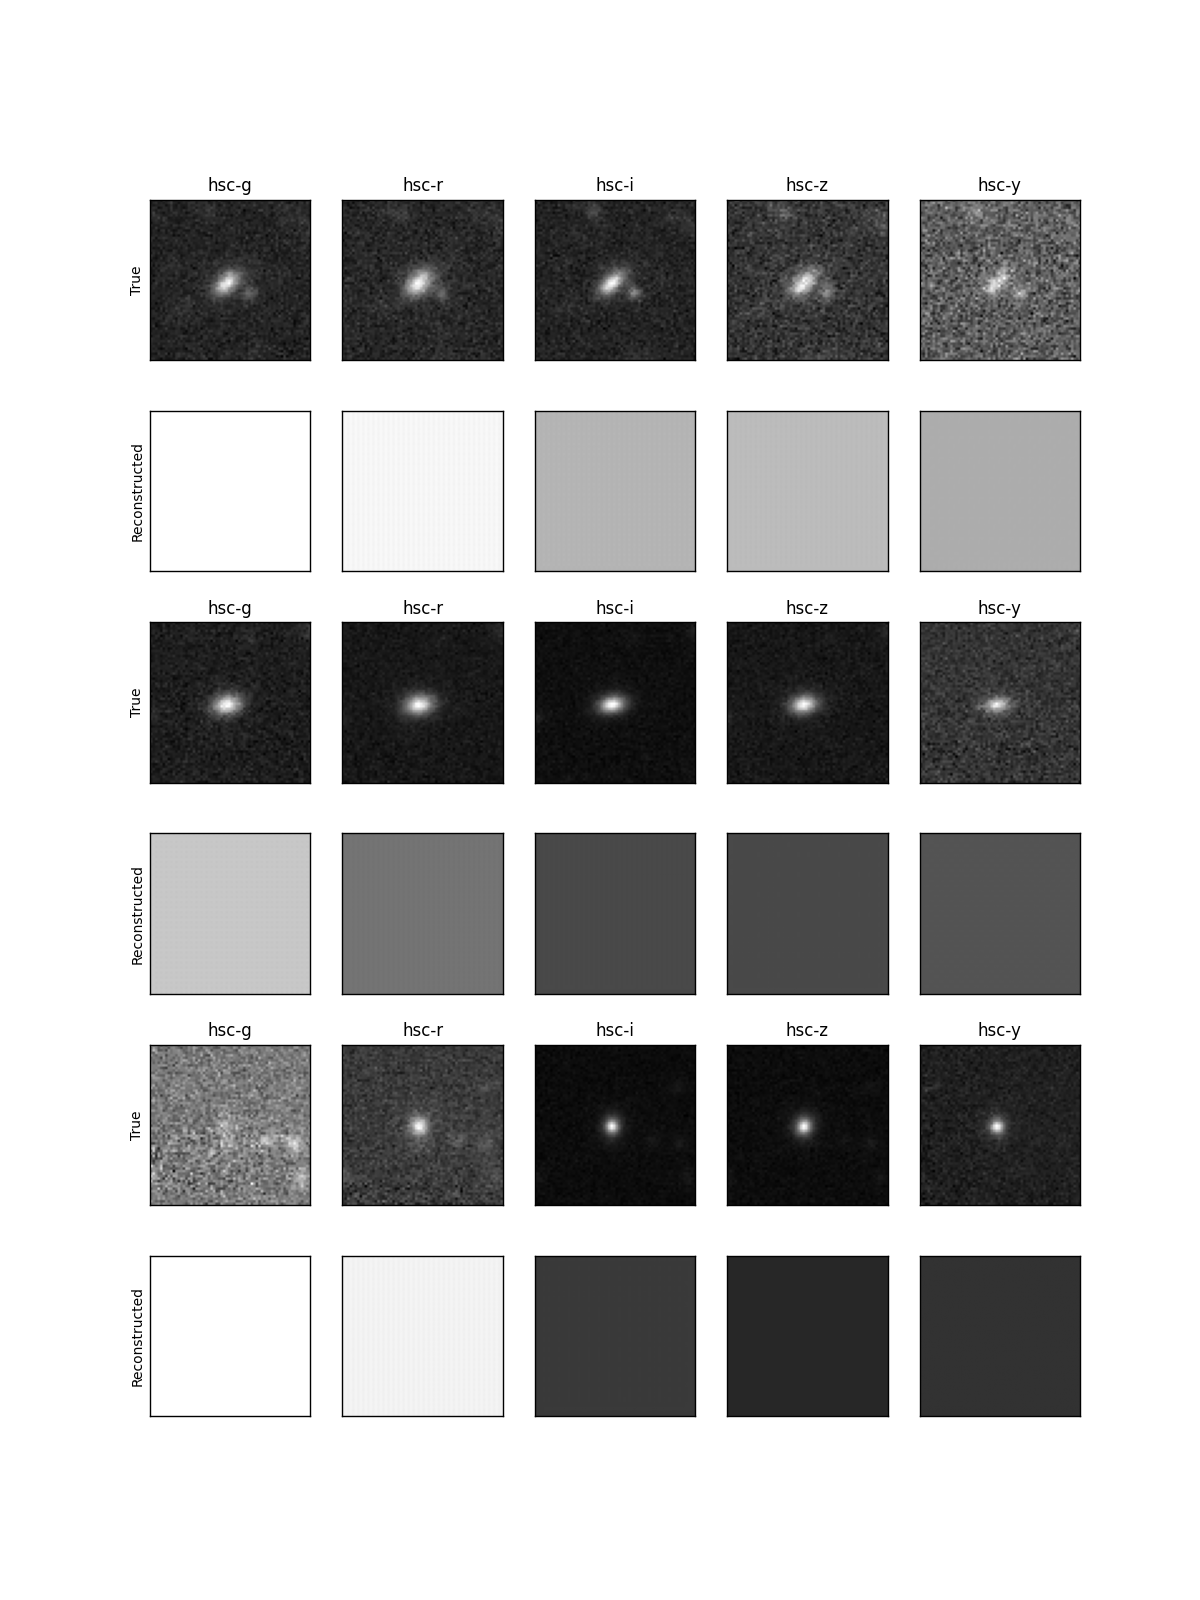

In [7]:
model.eval()
_n_plot = 3

# Extract only flux (first element of tuple) for visualization
imgs = torch.stack([dataset[i][0] for i in range(4)]).to(device)
with torch.no_grad():
    recs, _, _ = model(imgs)

fig, axs = plt.subplots(_n_plot * 2, n_bands, figsize=(12, 16))
for i in range(_n_plot):
    axs_row_true = axs[2 * i]
    axs_row_reco = axs[2 * i + 1]

    axs_row_true[0].set_ylabel("True")
    axs_row_reco[0].set_ylabel("Reconstructed")

    for j, band in enumerate(bands):
        minmax = {
            "vmin": imgs[i, j].cpu().min(),
            "vmax": imgs[i, j].cpu().max(),
        }
        axs_row_true[j].imshow(
            imgs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )
        axs_row_reco[j].imshow(
            recs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )

        axs_row_true[j].xaxis.set_ticks([])
        axs_row_true[j].yaxis.set_ticks([])
        axs_row_reco[j].xaxis.set_ticks([])
        axs_row_reco[j].yaxis.set_ticks([])
        axs_row_true[j].set_title(band)

## Train

In [8]:
from torch.utils.data import DataLoader, random_split
from galgenai.training import train

BATCH_SIZE = 256
NUM_WORKERS = 8
NUM_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
test_loader = DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    # scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    reconstruction_loss_fn="masked_weighted_mse",
    beta=1.0,
)

Training on device: cuda
Number of epochs: 10
Reconstruction loss: masked_weighted_mse
Beta: 1.0
------------------------------------------------------------

Epoch 1/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [03:14<00:00,  1.40it/s, loss=6242534.5000, recon=6240855.0000, kl=1679.4800]           


Epoch 1 Summary - Total Loss: 224308476.5480, Recon Loss: 15143711.9576, KL Loss: 209164771.9206

Epoch 2/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [03:13<00:00,  1.40it/s, loss=5152659.5000, recon=5150660.5000, kl=1999.2758]  


Epoch 2 Summary - Total Loss: 11316805.4649, Recon Loss: 11314507.1734, KL Loss: 2298.2543

Epoch 3/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [03:13<00:00,  1.40it/s, loss=7511818.5000, recon=7508493.5000, kl=3325.2566]  


Epoch 3 Summary - Total Loss: 11048103.3672, Recon Loss: 11042037.5646, KL Loss: 6065.8021

Epoch 4/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [03:11<00:00,  1.42it/s, loss=14113832.0000, recon=14112170.0000, kl=1663.1439]


Epoch 4 Summary - Total Loss: 10486173.3579, Recon Loss: 10484045.3487, KL Loss: 2128.0293

Epoch 5/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [03:06<00:00,  1.45it/s, loss=19979848.0000, recon=19977104.0000, kl=2743.5510]


Epoch 5 Summary - Total Loss: 9260678.2242, Recon Loss: 9258301.4723, KL Loss: 2376.7572

Epoch 6/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [03:13<00:00,  1.40it/s, loss=5032985.5000, recon=5029661.5000, kl=3323.7598]  


Epoch 6 Summary - Total Loss: 7775166.0554, Recon Loss: 7772218.4170, KL Loss: 2947.6300

Epoch 7/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [02:59<00:00,  1.51it/s, loss=6251418.0000, recon=6245506.0000, kl=5911.6172]  


Epoch 7 Summary - Total Loss: 5734017.8399, Recon Loss: 5729094.9631, KL Loss: 4922.8885

Epoch 8/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [03:13<00:00,  1.40it/s, loss=2516596.5000, recon=2508193.5000, kl=8402.9590]   


Epoch 8 Summary - Total Loss: 5020859.6748, Recon Loss: 5013984.1531, KL Loss: 6875.5123

Epoch 9/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [03:10<00:00,  1.42it/s, loss=3693690.7500, recon=3689559.0000, kl=4131.8442]  


Epoch 9 Summary - Total Loss: 4222757.5959, Recon Loss: 4216500.5503, KL Loss: 6257.0437

Epoch 10/10 (lr: 0.001000)


Training: 100%|██████████| 271/271 [03:18<00:00,  1.36it/s, loss=3259828.0000, recon=3252278.7500, kl=7549.2280]  

Epoch 10 Summary - Total Loss: 4020124.8487, Recon Loss: 4013112.1518, KL Loss: 7012.7043


## Check post-training outputs

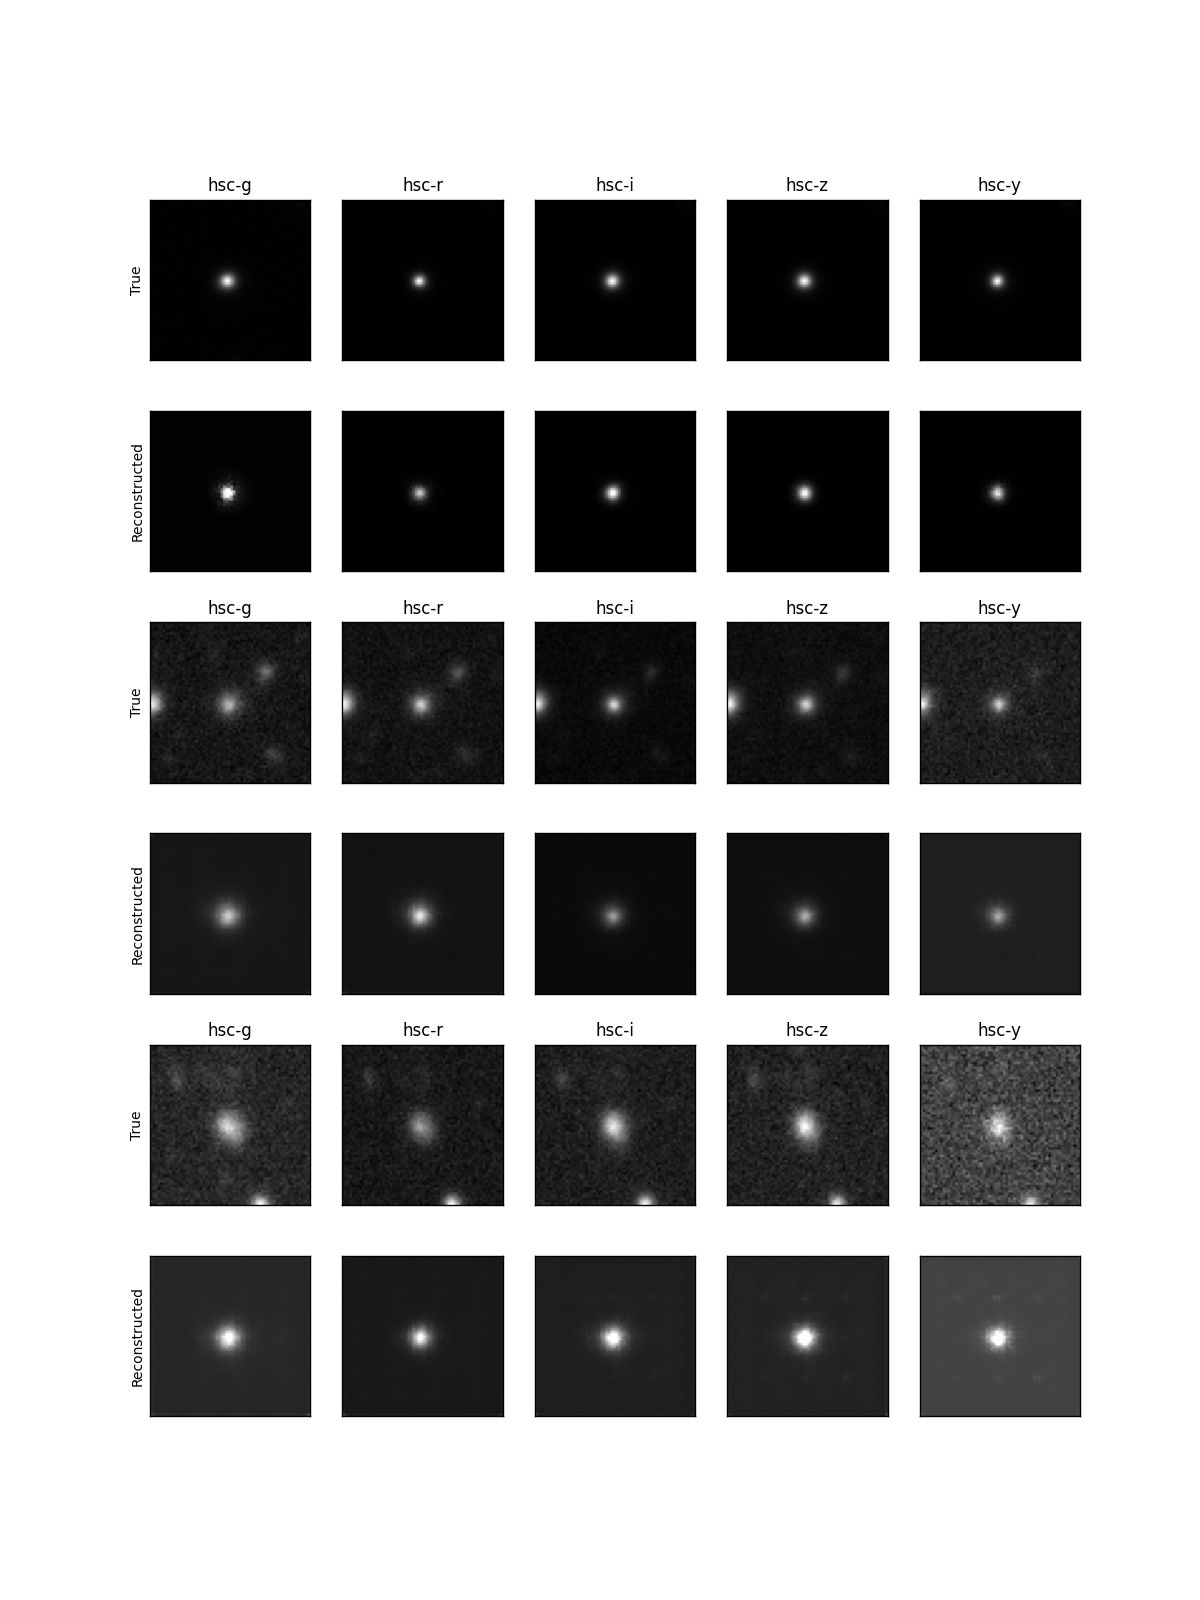

In [10]:
model.eval()
_n_plot = 3

# Extract only flux (first element of tuple) for visualization
imgs = torch.stack([dataset_test[i][0] for i in range(_n_plot)]).to(device)
with torch.no_grad():
    recs, _, _ = model(imgs)

fig, axs = plt.subplots(_n_plot * 2, n_bands, figsize=(12, 16))
for i in range(_n_plot):
    axs_row_true = axs[2 * i]
    axs_row_reco = axs[2 * i + 1]

    axs_row_true[0].set_ylabel("True")
    axs_row_reco[0].set_ylabel("Reconstructed")

    for j, band in enumerate(bands):
        minmax = {
            "vmin": imgs[i, j].cpu().min(),
            "vmax": imgs[i, j].cpu().max(),
        }
        axs_row_true[j].imshow(
            imgs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )
        axs_row_reco[j].imshow(
            recs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )

        axs_row_true[j].xaxis.set_ticks([])
        axs_row_true[j].yaxis.set_ticks([])
        axs_row_reco[j].xaxis.set_ticks([])
        axs_row_reco[j].yaxis.set_ticks([])
        axs_row_true[j].set_title(band)